# THIS NOTEBOOK INCLUDES HOW TO MAKE MODELS IN MDF

#### We define a Model name "model" using the command give some id to make it unique
 
 <div class="alert alert-block alert-info">
 mod = Model(id="Simple")
</div>

#### Define a graph name using name mod_graph using


<div class="alert alert-block alert-info">
 mod_graph = Graph(id="simple_example")
</div>

#### Add nodes and input some parameter


<div class="alert alert-block alert-info">
 a_node = Node(id="A", metadata={"color": "0 0.8 0"})
 a_node.parameters.append(Parameter(id="level", value=1.0))
 a_node.output_ports.append(OutputPort(id="output", value = "level"))
 mod_graph.nodes.append(a_node)
</div>

#### to make an Edge between two nodes lets a_node and b_node
<div class="alert alert-block alert-info">
 from modeci_mdf.utils import simple_connect
 e1 = simple_connect(a_node, b_node, mod_graph)
</div>

#### generate a graph image from the model

<div class="alert alert-block alert-info">
 mod.to_graph_image(
        engine="dot",
        output_format="png",
        view_on_render=False,
        level=3,
        filename_root="AB",
        is_horizontal=True
    )

 from IPython.display import Image
 Image(filename="AB.png")
</div>

#### To check the out put


<div class="alert alert-block alert-info">
 from modeci_mdf.execution_engine import EvaluableGraph
 eg = EvaluableGraph(mod_ graph, verbose=False)
 eg.evaluate()

print('Output of A: %s'%eg.enodes["A"].evaluable_outputs["output"].curr_value)
</div>

#### I have made a jupyter notebook file "Second_assignment_outreachy.ipynb" in that file I make three node and connected it with a mathematical function and change it to pytorch using MDF_to_PyTorch.py file

# MDF MODEL

It contains 4 nodes

Input ---> **A_node** ---> Sigmoid ---> Output ---> Input ---> **B_node** ---> tanh ---> Output ---> Input --->**C_node** ---> Time-Derivative-Function ---> Sigmoid --->Input ---> **D_node** ---> Probability ---> Output

In [1]:
from modeci_mdf.mdf import *
import onnx
mod = Model(id="Simple")
mod_graph = Graph(id="simple_example")
mod.graphs.append(mod_graph)

### 1.1 Create the first [Node](https://mdf.readthedocs.io/en/latest/api/Specification.html#node)
A Node defines the computational flow of a Model. It receives and transmits information via [Input](https://mdf.readthedocs.io/en/latest/api/Specification.html#inputport) and [Output ports](https://mdf.readthedocs.io/en/latest/api/Specification.html#outputport), and can have internal [parameters](https://mdf.readthedocs.io/en/latest/api/Specification.html#parameter). 

This node uses a sigmoid function

In [2]:
# Create a node
a_node = Node(id="A", metadata={"color": "0 0.8 0"})
# Add a parameter with a specific value
a_node.parameters.append(Parameter(id="level", value=1))
# logistic(variable0, gain, bias, offset) = 1/(1 + exp(-1*gain*(variable0 + bias) + offset))
f1 = Parameter(
    id="Logistic",
    function="logistic",
    args={"variable0": "level", "gain": 1, "bias": 0, "offset": 0},
    )
    
a_node.parameters.append(f1)

# Add an output port
a_node.output_ports.append(OutputPort(id="output", value = str(f1.id)))

# Add node to the graph
mod_graph.nodes.append(a_node)

# Print current structure as YAML
print(mod_graph.to_yaml())

# Add an input port: https://mdf.readthedocs.io/en/latest/api/Specification.html#inputport


simple_example:
    nodes:
        A:
            metadata:
                color: 0 0.8 0
            parameters:
                level:
                    value: 1
                Logistic:
                    function: logistic
                    args:
                        variable0: level
                        gain: 1
                        bias: 0
                        offset: 0
            output_ports:
                output:
                    value: Logistic



### 1.2 Create the Second [Node](https://mdf.readthedocs.io/en/latest/api/Specification.html#node)
A Node defines the computational flow of a Model. It receives and transmits information via [Input](https://mdf.readthedocs.io/en/latest/api/Specification.html#inputport) and [Output ports](https://mdf.readthedocs.io/en/latest/api/Specification.html#outputport), and can have internal [parameters](https://mdf.readthedocs.io/en/latest/api/Specification.html#parameter). 

This node uses a tanh function 

In [3]:
b_node = Node(id="B", metadata={"color": ".8 0 0"})


# Add an input port: https://mdf.readthedocs.io/en/latest/api/Specification.html#inputport
b_node.input_ports.append(InputPort(id="input"))

# Add some parameters : https://mdf.readthedocs.io/en/latest/api/Specification.html#parameter
b_node.parameters.append(Parameter(id="x_value", value="input"))

# Add a parameter which used the internal parameter as well as the value from the input
p1 = Parameter(
    id="tanh",
    function="onnx::Atanh",
    args={"input":"x_value"},
)
b_node.parameters.append(p1)
b_node.output_ports.append(OutputPort(id="output", value="tanh"))
mod_graph.nodes.append(b_node)

# Print current structure as YAML
print(mod_graph.to_yaml())

# Add an input port: https://mdf.readthedocs.io/en/latest/api/Specification.html#inputport


simple_example:
    nodes:
        A:
            metadata:
                color: 0 0.8 0
            parameters:
                level:
                    value: 1
                Logistic:
                    function: logistic
                    args:
                        variable0: level
                        gain: 1
                        bias: 0
                        offset: 0
            output_ports:
                output:
                    value: Logistic
        B:
            metadata:
                color: .8 0 0
            input_ports:
                input: {}
            parameters:
                x_value:
                    value: input
                tanh:
                    function: onnx::Atanh
                    args:
                        input: x_value
            output_ports:
                output:
                    value: tanh



### 1.3 Create the Third [Node](https://mdf.readthedocs.io/en/latest/api/Specification.html#node)
A Node defines the computational flow of a Model. It receives and transmits information via [Input](https://mdf.readthedocs.io/en/latest/api/Specification.html#inputport) and [Output ports](https://mdf.readthedocs.io/en/latest/api/Specification.html#outputport), and can have internal [parameters](https://mdf.readthedocs.io/en/latest/api/Specification.html#parameter). 

This node uses a statefull parameter and a sigmoid function 

In [4]:
c_node = Node(id="C", metadata={"color": ".8 0 0"})


# Add an input port: https://mdf.readthedocs.io/en/latest/api/Specification.html#inputport
c_node.input_ports.append(InputPort(id="input"))

# Add some parameters : https://mdf.readthedocs.io/en/latest/api/Specification.html#parameter
c_node.parameters.append(Parameter(id="t_value", value="input"))

# Add a parameter which used the internal parameter as well as the value from the input
p1 = Parameter(
    id="increment",
    value="increment+input",
)
c_node.parameters.append(p1)
p2 = Parameter(
    id="sigm",
    function="onnx::Atanh",
    args={"input":"increment"},
)
c_node.parameters.append(p2)

c_node.output_ports.append(OutputPort(id="output", value="sigm"))
mod_graph.nodes.append(c_node)

# Print current structure as YAML
print(mod_graph.to_yaml())

# Add an input port: https://mdf.readthedocs.io/en/latest/api/Specification.html#inputport


simple_example:
    nodes:
        A:
            metadata:
                color: 0 0.8 0
            parameters:
                level:
                    value: 1
                Logistic:
                    function: logistic
                    args:
                        variable0: level
                        gain: 1
                        bias: 0
                        offset: 0
            output_ports:
                output:
                    value: Logistic
        B:
            metadata:
                color: .8 0 0
            input_ports:
                input: {}
            parameters:
                x_value:
                    value: input
                tanh:
                    function: onnx::Atanh
                    args:
                        input: x_value
            output_ports:
                output:
                    value: tanh
        C:
            metadata:
                color: .8 0 0
            input_ports:
                input:

### 1.4 Create the Fourth [Node](https://mdf.readthedocs.io/en/latest/api/Specification.html#node)
A Node defines the computational flow of a Model. It receives and transmits information via [Input](https://mdf.readthedocs.io/en/latest/api/Specification.html#inputport) and [Output ports](https://mdf.readthedocs.io/en/latest/api/Specification.html#outputport), and can have internal [parameters](https://mdf.readthedocs.io/en/latest/api/Specification.html#parameter). 

This node uses a probability function 

In [5]:
d_node = Node(id="D", metadata={"color": ".8 0 0"})


# Add an input port: https://mdf.readthedocs.io/en/latest/api/Specification.html#inputport
d_node.input_ports.append(InputPort(id="input"))


# Add some parameters : https://mdf.readthedocs.io/en/latest/api/Specification.html#parameter
d_node.parameters.append(Parameter(id="p_value", value="input"))
p1 = Parameter(
    id="val",
    function="onnx::Round",
    args={"X":"p_value"},
)
d_node.parameters.append(p1)
# Add a parameter which used the internal parameter as well as the value from the input

d_node.output_ports.append(OutputPort(id="output", value="val"))

mod_graph.nodes.append(d_node)

# Print current structure as YAML
print(mod_graph.to_yaml())

# Add an input port: https://mdf.readthedocs.io/en/latest/api/Specification.html#inputport


simple_example:
    nodes:
        A:
            metadata:
                color: 0 0.8 0
            parameters:
                level:
                    value: 1
                Logistic:
                    function: logistic
                    args:
                        variable0: level
                        gain: 1
                        bias: 0
                        offset: 0
            output_ports:
                output:
                    value: Logistic
        B:
            metadata:
                color: .8 0 0
            input_ports:
                input: {}
            parameters:
                x_value:
                    value: input
                tanh:
                    function: onnx::Atanh
                    args:
                        input: x_value
            output_ports:
                output:
                    value: tanh
        C:
            metadata:
                color: .8 0 0
            input_ports:
                input:

In [6]:
mod.to_json_file("Machine Learning workflows using MDF_Export format _ functions.json")
mod.to_yaml_file("Machine Learning workflows using MDF_Export format _ functions.yaml")

'Machine Learning workflows using MDF_Export format _ functions.yaml'

In [7]:
#  This helper method just adds an edge connecting the first output port of 
# the pre node to the first input port of the post node
from modeci_mdf.utils import simple_connect

e1 = simple_connect(a_node, b_node, mod_graph)
e2 = simple_connect(b_node, c_node, mod_graph)
e3 = simple_connect(c_node, d_node, mod_graph)


# Print the current structure
print(mod_graph.to_yaml())


simple_example:
    nodes:
        A:
            metadata:
                color: 0 0.8 0
            parameters:
                level:
                    value: 1
                Logistic:
                    function: logistic
                    args:
                        variable0: level
                        gain: 1
                        bias: 0
                        offset: 0
            output_ports:
                output:
                    value: Logistic
        B:
            metadata:
                color: .8 0 0
            input_ports:
                input: {}
            parameters:
                x_value:
                    value: input
                tanh:
                    function: onnx::Atanh
                    args:
                        input: x_value
            output_ports:
                output:
                    value: tanh
        C:
            metadata:
                color: .8 0 0
            input_ports:
                input:

Converting MDF graph: simple_example to graphviz (level: 3, format: png)
    Node: A
Converting 0 0.8 0 to hex color
    Node: B
Converting .8 0 0 to hex color
    Node: C
Converting .8 0 0 to hex color
    Node: D
Converting .8 0 0 to hex color
    Edge: edge_A_B connects A to B
    Edge: edge_B_C connects B to C
    Edge: edge_C_D connects C to D
Written graph image to: Machine Learning workflows using MDF_Export format _ functions.png


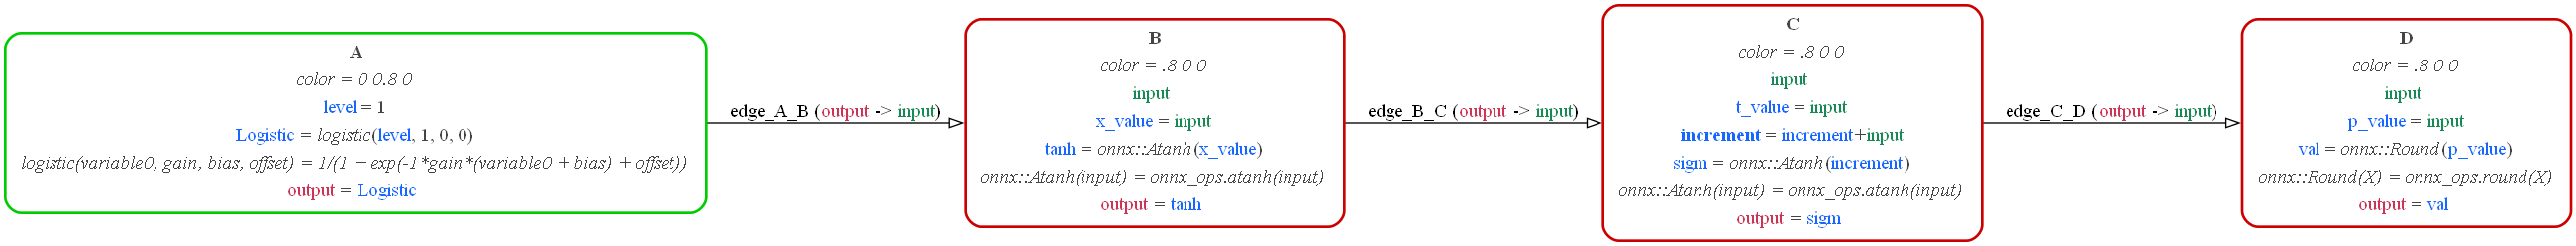

In [8]:
mod.to_graph_image(
        engine="dot",
        output_format="png",
        view_on_render=False,
        level=3,
        filename_root="Machine Learning workflows using MDF_Export format _ functions",
        is_horizontal=True
    )

from IPython.display import Image
Image(filename="Machine Learning workflows using MDF_Export format _ functions.png")

In [9]:
from modeci_mdf.execution_engine import EvaluableGraph

eg = EvaluableGraph(mod_graph, verbose=False)
eg.evaluate()
print('Output of A: %s'%eg.enodes["A"].evaluable_outputs["output"].curr_value)
print('Output of B: %s'%eg.enodes["B"].evaluable_outputs["output"].curr_value)
#Evaluating the Graph 5 more times using a time series & changing time increment by 1 
# (so count is 6 at the end, as it already has value 1)
dt = 1
duration = 5
t = 0
times = []
while t < duration:
    times.append(t)
    print("===== Evaluating at t = %s  ======" % (t))
    if t == 0:
        eg.evaluate(array_format=format)
    else:
        eg.evaluate(time_increment=dt)
    #notice that the output increments by 1 because of the stateful parameter setup on the node    
    print('Output of C: %s'%eg.enodes["C"].evaluable_outputs["output"].curr_value)  
    t += dt



print('Output of D: %s'%eg.enodes["D"].evaluable_outputs["output"].curr_value)


Init graph: simple_example
Evaluating graph: simple_example, root nodes: ['A'], with array format numpy
Output of A: 0.7310585786300049
Output of B: [0.62371254]
===== Evaluating at t = 0  ======
Evaluating graph: simple_example, root nodes: ['A'], with array format <built-in function format>
Output of C: [0.84755999]
===== Evaluating at t = 1  ======
Evaluating graph: simple_example, root nodes: ['A'], with array format numpy
Output of C: [0.95369709]
===== Evaluating at t = 2  ======
Evaluating graph: simple_example, root nodes: ['A'], with array format numpy
Output of C: [0.98647666]
===== Evaluating at t = 3  ======
Evaluating graph: simple_example, root nodes: ['A'], with array format numpy
Output of C: [0.99609661]
===== Evaluating at t = 4  ======
Evaluating graph: simple_example, root nodes: ['A'], with array format numpy
Output of C: [0.99887711]
Output of D: [1.]
